In [171]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import datasets, metrics, model_selection, svm
%matplotlib inline

# read in the json files
transcript = pd.read_csv('data/full_table_with_woe.csv')

In [172]:
print(transcript.columns)
transcript.shape
#plt.hist(transcript['gender_woe'])

Index(['Unnamed: 0', 'Unnamed: 0.1', 'person', 'event', 'time', 'days',
       'offer_id', 'amount', 'gender', 'age', 'became_member_on', 'income',
       'reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'sum_amount', 'offer_index_received', 'offer_is_completed',
       'amount_when_completed', 'selected_for_model_offer', 'train_test',
       'age_woe', 'income_woe', 'became_member_on_woe', 'gender_woe',
       'reward_woe', 'channels_woe', 'difficulty_woe', 'duration_woe',
       'offer_type_woe', 'age_bogo_woe', 'income_bogo_woe',
       'became_member_on_bogo_woe', 'gender_bogo_woe', 'channels_bogo_woe',
       'duration_bogo_woe', 'age_discount_woe', 'income_discount_woe',
       'became_member_on_discount_woe', 'gender_discount_woe',
       'channels_discount_woe', 'duration_discount_woe'],
      dtype='object')


(306534, 44)

## Summary of the "Data Processing" Notebook

We split the data in train y test subset, from this process we analyzed in train subset each variable if can be transfor in WoE variables. We end with a total of 5 variables.

# Modelling and Evaluation

## Modelling both offers type

In [361]:
## Transform data in arrays
woe_cols = ['age_woe','income_woe','became_member_on_woe','gender_woe','reward_woe','channels_woe','difficulty_woe', 'duration_woe', 'offer_type_woe']
X_train = transcript[transcript['train_test'] == 'train'][woe_cols].to_numpy()
Y_train = transcript[transcript['train_test'] == 'train']['offer_is_completed'].to_numpy()
X_test = transcript[transcript['train_test'] == 'test'][woe_cols].to_numpy()
Y_test = transcript[transcript['train_test'] == 'test']['offer_is_completed'].to_numpy()

In [362]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(test_preds, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """

    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1_score = 2*(precision*recall)/(precision + recall)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print("{:<11} {:.3f}".format('F1 Score:', f1_score))
        print()
        
    print("ROC Curve")
    metrics.plot_roc_curve(clf, X_test, Y_test)  
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

Metrics for Logistic Regression.

prediction (col)     0    1
actual (row)               
0                 1401  724
1                  333  928

Recall:     0.736
Precision:  0.562
Accuracy:   0.688
F1 Score:   0.637

ROC Curve


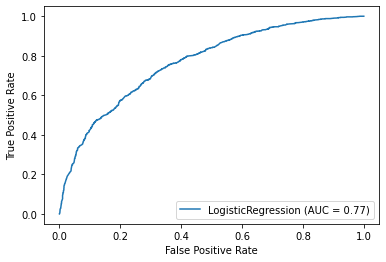

In [367]:
print('Metrics for Logistic Regression.\n') #penalty = 'l2', C = 1, class_weight = 'balanced'
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', class_weight = 'balanced').fit(X_train, Y_train)
test_preds = clf.predict(X_test)
train_preds = clf.predict(X_train)
train_labels = Y_train
test_labels = Y_test
ev = evaluate(test_preds, test_labels, verbose=True) # verbose means we'll print out the metrics

Metrics for Random Forest.

prediction (col)     0    1
actual (row)               
0                 1414  711
1                  346  915

Recall:     0.726
Precision:  0.563
Accuracy:   0.688
F1 Score:   0.634

ROC Curve


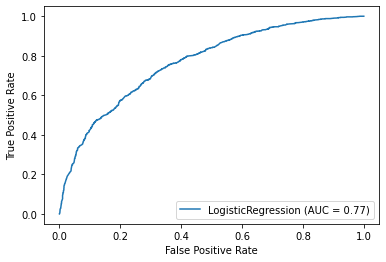

In [368]:
print('Metrics for Random Forest.\n')
RF = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0, class_weight = 'balanced')
RF.fit(X_train, Y_train)
RF.predict(X_train)
round(RF.score(X_train,Y_train), 4)
test_preds = RF.predict(X_test)
test_labels = Y_test
ev = evaluate(test_preds, test_labels, verbose=True) # verbose means we'll print out the metrics

Metrics for Neural Network.



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


prediction (col)     0    1
actual (row)               
0                 1814  311
1                  611  650

Recall:     0.515
Precision:  0.676
Accuracy:   0.728
F1 Score:   0.585

ROC Curve


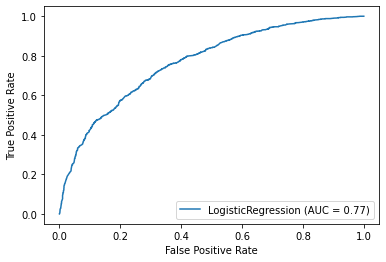

In [370]:
print('Metrics for Neural Network.\n')
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 2), random_state=1)
NN.fit(X_train, Y_train)
test_preds = NN.predict(X_test)
test_labels = Y_test
ev = evaluate(test_preds, test_labels, verbose=True) # verbose means we'll print out the metrics

## Modeling BOGO offers

In [371]:
## Transform data in arrays
woe_cols = ['age_bogo_woe', 'income_bogo_woe','became_member_on_bogo_woe', 'gender_bogo_woe', 'channels_bogo_woe', 'duration_bogo_woe']
condition_train = (transcript['train_test'] == 'train') & (transcript['offer_type'] == 'bogo')
condition_test = (transcript['train_test'] == 'test') & (transcript['offer_type'] == 'bogo')
X_train = transcript[condition_train][woe_cols].to_numpy()
Y_train = transcript[condition_train]['offer_is_completed'].to_numpy()
X_test = transcript[condition_test][woe_cols].to_numpy()
Y_test = transcript[condition_test]['offer_is_completed'].to_numpy()

Metrics for Logistic Regression.

prediction (col)    0    1
actual (row)              
0                 649  420
1                 159  431

Recall:     0.731
Precision:  0.506
Accuracy:   0.651
F1 Score:   0.598

ROC Curve


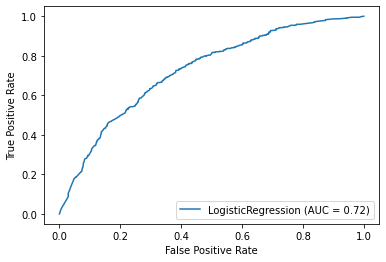

In [372]:
print('Metrics for Logistic Regression.\n')
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', class_weight = 'balanced').fit(X_train, Y_train)
test_preds = clf.predict(X_test)
train_preds = clf.predict(X_train)
train_labels = Y_train
test_labels = Y_test
ev = evaluate(test_preds, test_labels, verbose=True) # verbose means we'll print out the metrics

Metrics for Random Forest.

prediction (col)    0    1
actual (row)              
0                 689  380
1                 189  401

Recall:     0.680
Precision:  0.513
Accuracy:   0.657
F1 Score:   0.585

ROC Curve


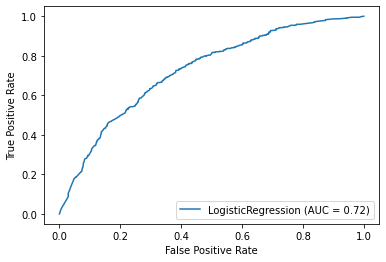

In [373]:
print('Metrics for Random Forest.\n')
RF = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0, class_weight = 'balanced')
RF.fit(X_train, Y_train)
RF.predict(X_train)
round(RF.score(X_train,Y_train), 4)
test_preds = RF.predict(X_test)
test_labels = Y_test
ev = evaluate(test_preds, test_labels, verbose=True) # verbose means we'll print out the metrics

Metrics for Neural Network.

prediction (col)    0    1
actual (row)              
0                 878  191
1                 304  286

Recall:     0.485
Precision:  0.600
Accuracy:   0.702
F1 Score:   0.536

ROC Curve


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


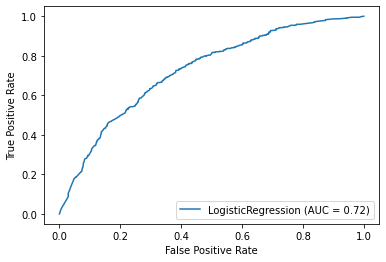

In [374]:
print('Metrics for Neural Network.\n')
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 2), random_state=1)
NN.fit(X_train, Y_train)
test_preds = NN.predict(X_test)
test_labels = Y_test
ev = evaluate(test_preds, test_labels, verbose=True) # verbose means we'll print out the metrics

## Modeling discount offer

In [375]:
## Transform data in arrays
woe_cols = ['age_discount_woe', 'income_discount_woe','became_member_on_discount_woe', 'gender_discount_woe', 'channels_discount_woe', 'duration_discount_woe']
condition_train = (transcript['train_test'] == 'train') & (transcript['offer_type'] == 'discount')
condition_test = (transcript['train_test'] == 'test') & (transcript['offer_type'] == 'discount')
X_train = transcript[condition_train][woe_cols].to_numpy()
Y_train = transcript[condition_train]['offer_is_completed'].to_numpy()
X_test = transcript[condition_test][woe_cols].to_numpy()
Y_test = transcript[condition_test]['offer_is_completed'].to_numpy()

Metrics for Logistic Regression.

prediction (col)    0    1
actual (row)              
0                 752  304
1                 178  493

Recall:     0.735
Precision:  0.619
Accuracy:   0.721
F1 Score:   0.672

ROC Curve


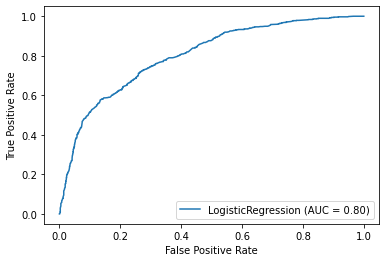

In [376]:
print('Metrics for Logistic Regression.\n')
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', class_weight = 'balanced').fit(X_train, Y_train)
test_preds = clf.predict(X_test)
train_preds = clf.predict(X_train)
train_labels = Y_train
test_labels = Y_test
ev = evaluate(test_preds, test_labels, verbose=True) # verbose means we'll print out the metrics

Metrics for Random Forest.

prediction (col)    0    1
actual (row)              
0                 711  345
1                 153  518

Recall:     0.772
Precision:  0.600
Accuracy:   0.712
F1 Score:   0.675

ROC Curve


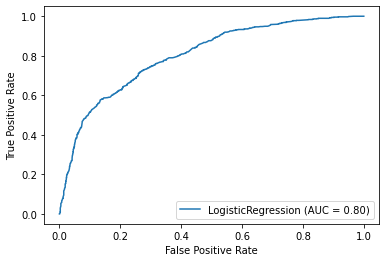

In [377]:
print('Metrics for Random Forest.\n')
RF = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0, class_weight = 'balanced')
RF.fit(X_train, Y_train)
RF.predict(X_train)
round(RF.score(X_train,Y_train), 4)
test_preds = RF.predict(X_test)
test_labels = Y_test
ev = evaluate(test_preds, test_labels, verbose=True) # verbose means we'll print out the metrics

Metrics for Neural Network.

prediction (col)    0    1
actual (row)              
0                 924  132
1                 294  377

Recall:     0.562
Precision:  0.741
Accuracy:   0.753
F1 Score:   0.639

ROC Curve


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


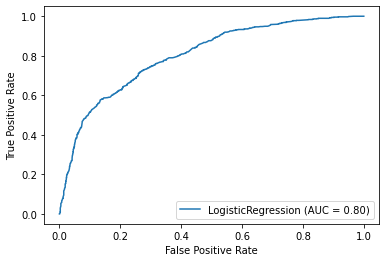

In [378]:
print('Metrics for Neural Network.\n')
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4, 2), random_state=1)
NN.fit(X_train, Y_train)
test_preds = NN.predict(X_test)
test_labels = Y_test
ev = evaluate(test_preds, test_labels, verbose=True) # verbose means we'll print out the metrics

## Results

|                           Model | Recall | Precision | Accuracy | F1 Score |
|--------------------------------:|--------|-----------|----------|----------|
| Both Offers - Logistic          | 0.74   | 0.56      | 0.69     | 0.64     |
| Both Offers - R. Forest         | 0.73   | 0.56      | 0.69     | 0.63     |
| Both Offers - Neural Network    | 0.52   | 0.67      | 0.73     | 0.58     |
| BOGO Offer - Logistic           | 0.73   | 0.51      | 0.65     | 0.60     |
| BOGO Offer - R. Forest          | 0.68   | 0.51      | 0.66     | 0.59     |
| BOGO Offer - Neural Network     | 0.49   | 0.60      | 0.70     | 0.54     |
| Discount Offer - Logistic       | 0.74   | 0.62      | 0.72     | 0.67     |
| Discount Offer - R. Forest      | 0.77   | 0.60      | 0.71     | 0.66     |
| Discount Offer - Neural Network | 0.56   | 0.74      | 0.75     | 0.64     |

## Extra Spending

In [357]:
transcript.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'person', 'event', 'time', 'days',
       'offer_id', 'amount', 'gender', 'age', 'became_member_on', 'income',
       'reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'sum_amount', 'offer_index_received', 'offer_is_completed',
       'amount_when_completed', 'selected_for_model_offer', 'train_test',
       'age_woe', 'income_woe', 'became_member_on_woe', 'gender_woe',
       'reward_woe', 'channels_woe', 'difficulty_woe', 'duration_woe',
       'offer_type_woe', 'age_bogo_woe', 'income_bogo_woe',
       'became_member_on_bogo_woe', 'gender_bogo_woe', 'channels_bogo_woe',
       'duration_bogo_woe', 'age_discount_woe', 'income_discount_woe',
       'became_member_on_discount_woe', 'gender_discount_woe',
       'channels_discount_woe', 'duration_discount_woe', 'extra_expending'],
      dtype='object')

In [358]:
transcript['extra_spending'] = transcript['amount_when_completed'] - transcript['difficulty']

Text(0.5, 1.0, 'Histogram of Extra Spending')

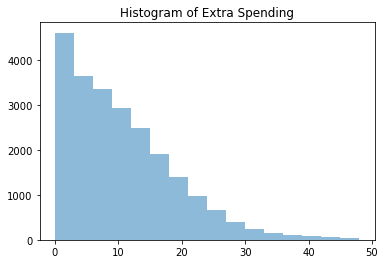

In [359]:
#cols = ['offer_type', 'difficulty', 'amount', 'amount_when_completed', 'offer_is_completed']
condition = (transcript['offer_is_completed'] == 1)
bins = np.arange(0, 50, 3) # fixed bin size
plt.hist(transcript[condition]['extra_spending'], bins=bins, alpha=0.5)
plt.title('Histogram of Extra Spending')

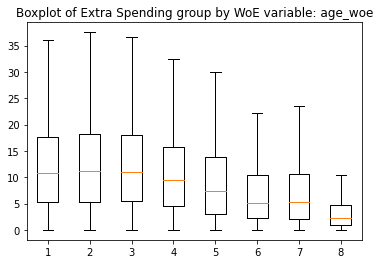

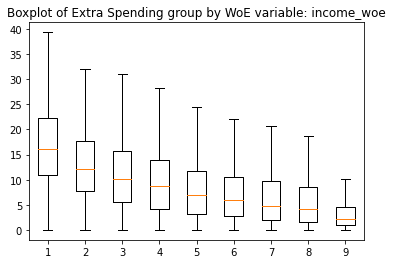

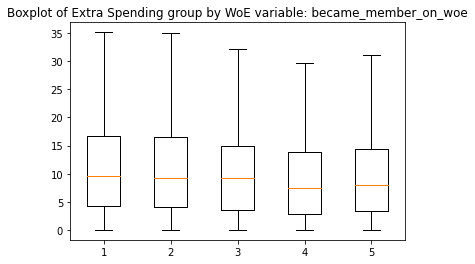

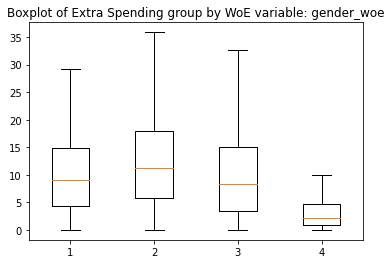

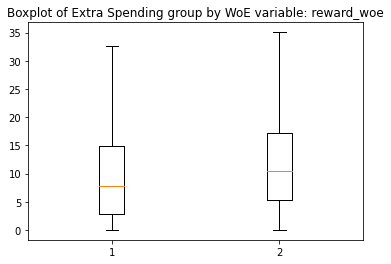

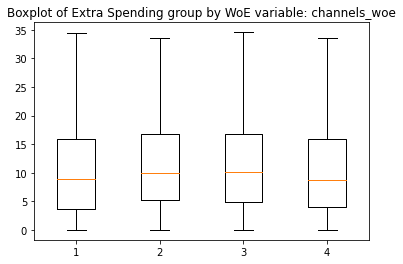

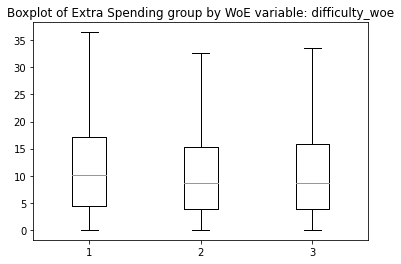

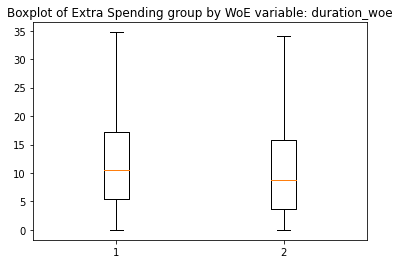

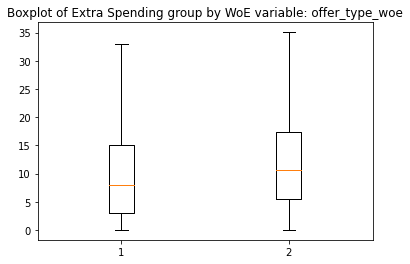

In [360]:
#transcript[condition].groupby(['difficulty'])['extra_expending'].std()
cols = ['age_woe', 'income_woe', 'became_member_on_woe', 'gender_woe', 'reward_woe', 'channels_woe', 'difficulty_woe', 'duration_woe', 'offer_type_woe']

for e in cols:
    ss = transcript[condition].groupby([e]).extra_expending.apply(list).reset_index()
    data = []
    for index, row in ss.iterrows(): 
        data.append(row.values.tolist()[1])
    fig, ax = plt.subplots()
    ax.boxplot(data, 0, '')
    ax.set_title('Boxplot of Extra Spending group by WoE variable: '+ e)
    plt.show()

In [384]:
pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.12.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
applaunchservices                  0.2.1
appnope                            0.1.0
appscript                          1.1.1
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1

Note: you may need to restart the kernel to use updated packages.
